In [1]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    BayesianRidge,
    Ridge,
    ElasticNetCV,
    ElasticNet,
    Lasso,
    LassoCV,
    LarsCV,
    LassoLarsCV,
    SGDRegressor,
    TheilSenRegressor,
    RANSACRegressor,
)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, RepeatedKFold, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

In [2]:
model_folders = [
    # cherubic-nifty-serval - deberta-large - 0.4836
    "20210614-173633",
    "20210614-203831",
    "20210614-234025",
    "20210615-024138",
    "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base - 0.4934
    "20210615-084357",
    "20210615-094729",
    "20210615-105329",
    "20210615-120001",
    "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden) - 0.4961
    "20210615-220146",
    "20210615-225055",
    "20210615-234038",
    "20210616-003038",
    "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large - 0.4890
    "20210616-021135",
    "20210616-041221",
    "20210616-060255",
    "20210616-075451",
    "20210616-094506",
    # mottled-certain-caracal - distilroberta-base - 0.5076
    "20210616-113626",
    "20210616-121203",
    "20210616-124738",
    "20210616-132341",
    "20210616-140300",
    # aspiring-classic-pegasus - funnel - 0.4975
    "20210617-083847", 
    "20210617-102611", 
    "20210617-120949", 
    "20210617-135233", 
    "20210617-153459", 
    # silver-bumblebee-of-attack - roberta-base - 0.4932
    "20210617-223340",
    "20210617-232650",
    "20210618-002022",
    "20210618-011405",
    "20210618-020751",
    # sloppy-resourceful-tanuki - albert-large - 0.5241
    "20210617-225903",
    "20210618-010302",
    "20210618-030706",
    "20210618-051049",
    "20210618-071437",
    # rustling-quirky-mastodon - bert-base-uncased - 0.5136
    "20210618-082756",
#     "20210618-092115",  # Only 4 ckpts
    "20210618-100526",
    "20210618-105909",
    "20210618-115253",
    # perky-defiant-husky - bert-large-uncased - 0.5287
    "20210618-124637",
    "20210618-144213",
    "20210618-163942",
    "20210618-183719",
    "20210618-203441",
    # gregarious-brass-perch - bart-base - 0.5445
    "20210618-223208",
    "20210618-233614",
    "20210619-004022",
    "20210619-014809",
    "20210619-025421",
    # military-firefly-of-apotheosis - bart-large - 0.5301
    "20210619-035747",
    "20210619-064351",
    "20210619-093050",
    "20210619-121916",
    "20210619-150740",
    # eccentric-lemur-of-tenacity - sentence-transformers/LaBSE - 0.5230
    "20210622-152356",
    "20210622-161822",
    "20210622-171312",
    "20210622-181238",
    "20210622-191326",
    # valiant-chameleon-of-chaos - sentence-transformers/bert-base-nli-cls-token - 0.5288
    "20210622-165808",
    "20210622-174555",
    "20210622-183427",
    "20210622-192221",
    "20210622-201127",
    # nonchalant-quaint-termite - roberta-base - 0.4951
    "20210623-093223",
    "20210623-101956",
    "20210623-110954",
    "20210623-120004",
    "20210623-125025",
    # skilled-smart-crane - deberta-large (new seeds) - 0.4758
    "20210623-105940",
    "20210623-140343",
    "20210623-170657",
    "20210623-201514",
    "20210623-232231",
    # winged-cerise-agouti - roberta-large - 0.4986
    "20210623-134115",
    "20210623-153240",
    "20210623-172217",
    "20210623-191151",
    "20210623-210342",
    # swift-of-amazing-pride - distilroberta-base - 0.5053
    "20210623-225426",
    "20210623-233019",
    "20210624-000706",
    "20210624-004429",
    "20210624-012102",
    # independent-discerning-earthworm - albert-large-v2
    "20210624-015812",
    "20210624-040309",
    "20210624-060838",
    "20210624-081317",
    "20210624-101855",
    # discreet-visionary-seahorse - microsoft/deberta-base - 0.5181
    "20210624-023057",
    "20210624-033624",
    "20210624-044356",
    "20210624-055212",
    "20210624-070123",
    # chirpy-wren-of-unity - funnel-transformer/large-base - 0.5000
    "20210624-081031",
    "20210624-095223",
    "20210624-113506",
    "20210624-131927",
    "20210624-150250",
    # free-ebony-fennec - microsoft/deberta-base - 0.5021
    "20210627-105133",
    "20210627-115742",
    "20210627-130650",
    "20210627-141604",
    "20210627-152616",
    # blond-viper-of-discussion - deepset/roberta-base-squad2 - 0.4900
    "20210627-105144",
    "20210627-114225",
    "20210627-123605",
    "20210627-133047",
    "20210627-142510",
    # meticulous-demonic-kakapo - roberta-large - 0.5030
    "20210627-151904",
    "20210627-171236",
    "20210627-190737",
    "20210627-210244",
    "20210627-225949",
    # fat-glorious-badger - deepset/roberta-large-squad2 - 0.4937
    "20210628-005835",
    "20210628-025632",
    "20210628-045559",
    "20210628-065437",
    "20210628-085322",
    # beautiful-denim-monkey - funnel-transformer/large-base - 0.5066
    "20210627-163614",
    "20210627-181626",
    "20210627-195827",
    "20210627-213946",
    "20210627-232205",
    # solid-zebu-of-happiness - albert-large-v2 - 0.5207
    "20210628-010737",
    "20210628-031447",
    "20210628-052149",
    "20210628-072849",
    "20210628-093543",
    # parrot-of-strange-maturity - sentence-transformers/LaBSE - 0.5286
    "20210628-114738",
    "20210628-125350",
    "20210628-135845",
    "20210628-150440",
    "20210628-161040",
    # greedy-dog-of-holiness - microsoft/deberta-large - 0.4756
    "20210628-114736",
    "20210628-145921",
    "20210628-181426",
    "20210628-212819",
    "20210629-004241",
    # truthful-hissing-waxbill - deepset/sentence_bert - 0.5504
    "20210628-171705",
    "20210628-180837",
    "20210628-190059",
    "20210628-195246",
    "20210628-204527",
    # blazing-natural-husky - bert-large-cased-whole-word-masking - 0.5202
    "20210628-213743",
    "20210628-233312",
    "20210629-012726",
    "20210629-032224",
    "20210629-051503",
    # ludicrous-heron-of-genius - bert-large-cased
    "20210629-035901",
    "20210629-055338",
    "20210629-074730",
    "20210629-094209",
    "20210629-113421",
    # cooperative-mink-of-spirit - xlm-roberta-base
    "20210629-081350",
    "20210629-091723",
    "20210629-102123",
    "20210629-112540",
    "20210629-122949",
    # dangerous-nebulous-horse - xlm-roberta-large - 0.5092
    "20210629-133352",
    "20210629-154453",
    "20210629-183058",
    "20210629-203803",
    "20210629-224305",
    # passionate-sexy-slug - bart-base - 0.5325
    "20210629-132611",
    "20210629-142628",
    "20210629-152921",
    "20210629-163239",
    "20210629-183052",
    # fascinating-lavender-turaco - electra-large - 
    "20210705-091644",
    # simple-sensible-bear - electra-large - 0.51669
    "20210705-143109",
    "20210705-162253",
    "20210705-181532",
    "20210705-200803",
    "20210705-215844",
    # aquatic-nostalgic-honeybee - electra-large - 0.51102 (KL loss)
    "20210706-185121",
    "20210706-204235",
    "20210706-223346",
    "20210707-002647",
    "20210707-022001",
    # melodic-snobbish-wrasse - sentence-transformers/paraphrase-mpnet-base-v2 - 0.5104
    "20210710-085905",
    "20210710-095408",
    "20210710-105043",
    "20210710-114855",
    "20210710-124531",
    # truthful-hummingbird-of-focus -google/bigbird-roberta-large - 0.5293
    "20210710-083949",
    "20210710-105221",
    "20210710-130717",
    "20210710-152140",
    "20210710-173710",
]

print(len(model_folders))

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

195


In [3]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(model_folders), len(oof_paths)

(195, 195)

In [4]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders

print(len(pred_cols))
    
oofs.head()

195


,id,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,...,20210710-085905,20210710-095408,20210710-105043,20210710-114855,20210710-124531,20210710-083949,20210710-105221,20210710-130717,20210710-152140,20210710-173710
1279,000accf7e,-2.002055,0.497274,-2.174165,-2.305160,-2.451190,-2.505858,-2.490587,-2.264506,-2.664520,...,-2.451322,-2.442556,-2.673328,-2.544662,-2.356542,-2.433604,-2.352290,-2.457826,-2.559311,-2.667193
2185,001ef05a9,0.841000,0.492411,0.669889,0.569387,0.472606,0.514734,0.493645,0.528904,0.495011,...,0.592653,0.485817,0.259346,0.804812,0.394737,-0.079809,0.017005,0.045347,0.498888,0.373763
332,00589d631,-2.195109,0.520239,-1.908255,-1.930197,-2.064695,-2.545308,-2.129548,-2.160540,-2.234235,...,-1.791372,-1.743310,-1.754651,-1.487657,-1.975078,-2.024573,-1.884771,-2.114053,-2.019015,-2.306566
72,0060c36b9,-1.333456,0.492384,-1.098570,-1.134784,-1.161226,-1.260594,-1.139692,-0.983574,-1.220255,...,-0.622495,-1.186044,-0.603003,-0.910984,-0.946105,-1.135062,-1.009917,-1.150199,-1.122957,-1.156714
2694,00d4d251d,0.088764,0.463817,-0.226934,-0.034609,-0.219147,-0.192564,0.082993,-0.454333,-0.133543,...,-0.062366,-0.465522,-0.197102,-0.267425,0.249068,0.251939,-0.457682,0.103368,0.165548,0.195490


In [5]:
oofs.describe()

,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,...,20210710-085905,20210710-095408,20210710-105043,20210710-114855,20210710-124531,20210710-083949,20210710-105221,20210710-130717,20210710-152140,20210710-173710
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.948092,-0.939186,-0.936123,-0.968496,-0.958907,-0.891844,-0.910382,-0.932254,...,-0.944127,-0.925067,-0.918040,-0.932669,-0.921113,-0.920482,-0.921432,-0.928067,-0.909958,-0.911464
std,1.033579,0.034818,0.912312,0.889185,0.913707,0.930968,0.905059,0.907261,0.927470,0.911461,...,0.915422,0.911523,0.909103,0.924004,0.918001,0.879174,0.867048,0.900036,0.872063,0.882588
min,-3.676268,0.000000,-3.560785,-3.392829,-3.732013,-3.534283,-3.483280,-3.612729,-3.607502,-3.599687,...,-3.871735,-3.721772,-3.547512,-3.632431,-3.644846,-3.607702,-3.409277,-3.289720,-3.700936,-3.534374
25%,-1.690320,0.468543,-1.613250,-1.570393,-1.616401,-1.659845,-1.625832,-1.550567,-1.581456,-1.592230,...,-1.603585,-1.596125,-1.577070,-1.589348,-1.594397,-1.574786,-1.545850,-1.660455,-1.514295,-1.544298
50%,-0.912190,0.484721,-0.900925,-0.891787,-0.904669,-0.926716,-0.913854,-0.845645,-0.853657,-0.858941,...,-0.883252,-0.863185,-0.857151,-0.867780,-0.851400,-0.868739,-0.875356,-0.854468,-0.866046,-0.875494
75%,-0.202540,0.506268,-0.242909,-0.258008,-0.232878,-0.260776,-0.254002,-0.191775,-0.206128,-0.229850,...,-0.234064,-0.201745,-0.204487,-0.230099,-0.212440,-0.236294,-0.215183,-0.108021,-0.232907,-0.234612
max,1.711390,0.649671,1.249225,1.150385,1.232993,1.288711,1.167053,1.241939,1.432130,1.164523,...,1.362912,1.198112,1.260274,1.279471,1.300148,1.273104,1.110044,0.982620,1.204302,1.293153


# Add `textstat` features

In [6]:
import textstat

In [7]:
train = pd.read_csv(INPUT_PATH / "train.csv")

ts_features = [
    "flesch_reading_ease",
    "smog_index",
    "flesch_kincaid_grade",
    "coleman_liau_index",
    "automated_readability_index",
    "dale_chall_readability_score",
    "difficult_words",
    "linsear_write_formula",
    "gunning_fog",
#     "text_standard",
    "fernandez_huerta",
    "szigriszt_pazos",
    "gutierrez_polini",
    "crawford",
]

ts_df = []

for _, row in train.iterrows():
    data = {"id": row["id"]}
    for f in ts_features:
        data[f] = getattr(textstat, f)(str(row["excerpt"]))
    ts_df.append(data)
        
ts_df = pd.DataFrame(ts_df)
ts_df.head()

,id,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford
0,c12129c31,80.31,8.6,6.1,8.06,8.3,6.65,25,9.000000,8.31,112.2,112.25,46.59,1.5
1,85aa80a4c,82.54,8.3,5.2,6.78,7.2,5.92,17,7.285714,7.53,114.5,110.91,49.06,1.6
2,b69ac6792,75.74,10.1,7.9,7.20,10.1,6.29,17,14.750000,10.49,107.6,107.65,47.03,1.8
3,dd1000b26,72.02,6.7,11.4,8.54,16.4,6.61,14,12.500000,13.61,101.4,99.58,41.49,1.8
4,37c1b32fb,75.47,8.8,10.0,4.83,11.8,1.57,1,13.500000,11.76,104.9,105.39,48.95,1.6


# Hill climbing

In [8]:
# https://www.kaggle.com/abhishek/step-1-create-folds
def create_folds(data, y, n_splits=5, random_state=None):
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))

    # bin targets
    data.loc[:, "bins"] = pd.cut(y, bins=num_bins, labels=False)

    # initiate the kfold class from model_selection module
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    splits = []

    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        splits.append((t_, v_))
        
    return splits

In [9]:
def get_score(X, y, ridge=True):
    if ridge:
        reg = RidgeCV(
            alphas=(
                0.0001,
                0.0005,
                0.001,
                0.005,
                0.01,
                0.05,
                0.1,
                0.5,
                1.0,
                5.0,
                10.0,
                50,
                100,
                500,
                1000,
            ),
            normalize=True,
        )
        reg.fit(X, y)
        return np.sqrt(-reg.best_score_)
    else:
        reg = LassoCV(
            max_iter=20000,
            random_state=48,
            n_jobs=-1,
            normalize=True,
            tol=1e-5,
            #         cv=RepeatedKFold(random_state=48),
            cv=create_folds(X, y, random_state=48),
            selection="random",
        ).fit(X, y)
        return np.sqrt(reg.mse_path_)[-1].mean()


def averaging(X, y):
    y_pred = X.mean(1)
    return np.sqrt(mean_squared_error(y_pred, y))

In [10]:
def get_size(folder):
    # Ubuntu uses 1000**3, Kaggle use 1024**3
    return sum(f.stat().st_size for f in (OUTPUT_PATH / folder).rglob('*') if f.is_file()) / 1024**3


def get_model_name(folder):
    for f in (OUTPUT_PATH / folder).rglob('*.yaml'):
        with open(f, "r") as ymlfile:
            cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
            return cfg["model_name"]
                
def get_rmse(folder):
    return np.sqrt(mean_squared_error(oofs[folder], oofs["target"]))


def plot_heatmap(selection):
    corr = oofs[selection].corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [11]:
# candidates = model_folders.copy()

# best_score = np.inf
# selection = []
# # tol = 0.00001
# tol = 0
# y = oofs["target"]
# storage = 0

# # Find best initial model
# initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
# idx = np.argmin(initial_scores)
# best_score = initial_scores[idx]
# selection.append(candidates[idx])
# storage += get_size(candidates[idx])
# print(f"Initial {candidates[idx]}. Score {best_score:0.5f}. {storage:0.1f} GB")
# del candidates[idx]


# while storage < 120:
#     scores = [get_score(oofs[selection + [c]], y) for c in candidates]

#     idx = np.argmin(scores)
#     if scores[idx] < best_score - tol:
#         best_score = scores[idx]
#         selection.append(candidates[idx])
#         storage += get_size(candidates[idx])
#         print(f"Added {candidates[idx]}. New best score {best_score:0.5f}. {storage:0.1f} GB")
#         del candidates[idx]
#     else:
#         break
        
# print(len(selection), "models selected")
        
# selection

# Netflix method

https://kaggler.readthedocs.io/en/latest/_modules/kaggler/ensemble/linear.html#netflix

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf

In [12]:
# https://kaggler.readthedocs.io/en/latest/_modules/kaggler/ensemble/linear.html#netflix
def netflix(es, ps, e0, l=.0001):
    """Combine predictions with the optimal weights to minimize RMSE.

    Ref: Töscher, A., Jahrer, M., & Bell, R. M. (2009). The bigchaos solution to the netflix grand prize.

    Args:
        es (list of float): RMSEs of predictions
        ps (list of np.array): predictions
        e0 (float): RMSE of all zero prediction
        l (float): lambda as in the ridge regression

    Returns:
        (tuple):

            - (np.array): ensemble predictions
            - (np.array): weights for input predictions
    """
    m = len(es)
    n = len(ps[0])

    X = np.stack(ps).T
    pTy = .5 * (n * e0**2 + (X**2).sum(axis=0) - n * np.array(es)**2)

    w = np.linalg.pinv(X.T.dot(X) + l * n * np.eye(m)).dot(pTy)

    return X.dot(w), w

In [13]:
# preds = [oofs[c].values for c in selection[:20]]
# rmses = [np.sqrt(mean_squared_error(p, oofs["target"])) for p in preds]

In [14]:
# kf = KFold(5, shuffle=True, random_state=48)

# for i in range(-8, 1):
#     scores = []
#     for fold, (trn_idx, val_idx) in enumerate(kf.split(oofs)):
#         train_oofs = oofs.loc[trn_idx]
#         valid_oofs = oofs.loc[val_idx]

#         train_preds = [train_oofs[c].values for c in selection[:20]]    
#         _, weights = netflix(rmses, train_preds, 1.4100, 10**i)

#         val_pred = valid_oofs[selection[:20]] @ weights
#         score = np.sqrt(mean_squared_error(val_pred, valid_oofs["target"]))
#         scores.append(score)
#         # print(f"Fold {fold}, RMSE: {score:0.5f}")

#     print(f"L: {10**i}, Final RMSE: {np.mean(scores):0.5f}")

# Netflix hillclimb

In [15]:
def get_nf_score(X, y=oofs["target"], cv=True):
    if cv:
        scores = []
        weights_agg = 0
        for seed in [48, 42, 3]:
            for fold, (trn_idx, val_idx) in enumerate(create_folds(X, y, random_state=seed)):
                train_oofs = X.loc[trn_idx]
                valid_oofs = X.loc[val_idx]
                train_target = y.loc[trn_idx]
                valid_target = y.loc[val_idx]

                train_preds = [train_oofs[c].values for c in X.columns]    
                rmses = [np.sqrt(mean_squared_error(X[c], y)) for c in X.columns]
#                 rmses = [np.sqrt(mean_squared_error(train_oofs[c], train_target)) for c in X.columns]
                _, weights = netflix(rmses, train_preds, 1.4100)

                val_pred = valid_oofs @ weights
                score = np.sqrt(mean_squared_error(val_pred, valid_target))
                scores.append(score)
                weights_agg += weights
                
        weights_agg /= len(scores)
        return np.mean(scores)
    else:
        preds = [X[c].values for c in X.columns] 
        rmses = [np.sqrt(mean_squared_error(X[c], y)) for c in X.columns]
        ensemble, weights = netflix(rmses, preds, 1.4100)
        return np.sqrt(mean_squared_error(ensemble, y))

In [16]:
get_nf_score(oofs[model_folders])

0.4328648084661039

In [17]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
tol = 0
y = oofs["target"]
storage = 0

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], y)) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
storage += get_size(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}. {storage:0.1f} GB")

table = []
record = {
    "folder": candidates[idx],
    "model": get_model_name(candidates[idx]),
    "model_rmse": get_rmse(candidates[idx]),
    "best_score": best_score,
    "storage": storage,
}
table.append(record)
del candidates[idx]

while storage < 200:
#     scores = [get_score(oofs[selection + [c]], y) for c in candidates]
    scores = [get_nf_score(oofs[selection + [c]], y, False) for c in candidates]
#     scores = [get_nf_score(oofs[selection + [c]], y, True) for c in candidates]

    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        storage += get_size(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}. {storage:0.1f} GB")
        record = {
            "folder": candidates[idx],
            "model": get_model_name(candidates[idx]),
            "model_rmse": get_rmse(candidates[idx]),
            "best_score": best_score,
            "storage": storage,
        }
        table.append(record)
        del candidates[idx]
        
    else:
        break
        
print(len(selection), "models selected")
table = pd.DataFrame(table)
selection  # 0.44098. 96.2 GB

Initial 20210628-145921. Score 0.47120. 7.6 GB
Added 20210624-150250. New best score 0.45940. 14.3 GB
Added 20210616-041221. New best score 0.45466. 20.9 GB
Added 20210623-232231. New best score 0.45216. 28.5 GB
Added 20210624-012102. New best score 0.45052. 30.1 GB
Added 20210619-004022. New best score 0.44885. 32.7 GB
Added 20210617-135233. New best score 0.44752. 39.4 GB
Added 20210619-035747. New best score 0.44654. 47.0 GB
Added 20210624-101855. New best score 0.44563. 47.4 GB
Added 20210628-045559. New best score 0.44480. 54.0 GB
Added 20210618-223208. New best score 0.44417. 56.7 GB
Added 20210710-173710. New best score 0.44360. 63.4 GB
Added 20210710-124531. New best score 0.44317. 65.4 GB
Added 20210624-015812. New best score 0.44271. 65.8 GB
Added 20210627-105144. New best score 0.44228. 68.2 GB
Added 20210705-162253. New best score 0.44192. 74.4 GB
Added 20210627-152616. New best score 0.44154. 77.0 GB
Added 20210615-094729. New best score 0.44124. 79.6 GB
Added 20210627-213

['20210628-145921',
 '20210624-150250',
 '20210616-041221',
 '20210623-232231',
 '20210624-012102',
 '20210619-004022',
 '20210617-135233',
 '20210619-035747',
 '20210624-101855',
 '20210628-045559',
 '20210618-223208',
 '20210710-173710',
 '20210710-124531',
 '20210624-015812',
 '20210627-105144',
 '20210705-162253',
 '20210627-152616',
 '20210615-094729',
 '20210627-213946',
 '20210624-113506',
 '20210624-044356',
 '20210619-064351',
 '20210628-085322',
 '20210628-031447',
 '20210618-183719',
 '20210629-183058',
 '20210629-163239',
 '20210623-201514',
 '20210614-203831',
 '20210628-114738',
 '20210627-105133',
 '20210628-212819',
 '20210619-093050',
 '20210629-012726',
 '20210629-035901',
 '20210627-151904',
 '20210629-224305']

In [18]:
table

,folder,model,model_rmse,best_score,storage
0,20210628-145921,microsoft/deberta-large,0.471197,0.471197,7.582353
1,20210624-150250,funnel-transformer/large-base,0.491098,0.459396,14.292835
2,20210616-041221,deepset/roberta-large-squad2,0.482696,0.454664,20.947465
3,20210623-232231,microsoft/deberta-large,0.471707,0.452156,28.529799
4,20210624-012102,distilroberta-base,0.502802,0.450523,30.085750
5,20210619-004022,facebook/bart-base,0.556662,0.448849,32.709297
6,20210617-135233,funnel-transformer/large-base,0.495666,0.447515,39.419779
7,20210619-035747,facebook/bart-large,0.543126,0.446538,47.023267
8,20210624-101855,albert-large-v2,0.506411,0.445635,47.384934
9,20210628-045559,deepset/roberta-large-squad2,0.489583,0.444804,54.039584


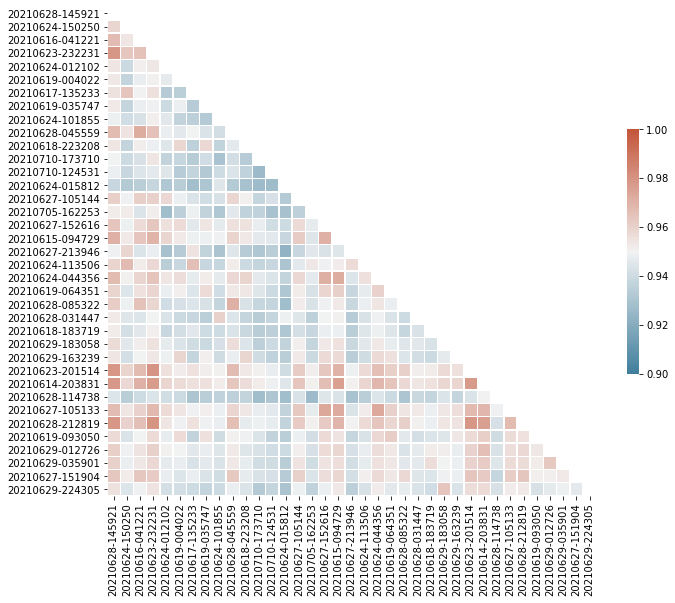

In [19]:
plot_heatmap(selection)

In [20]:
model_folders_current = [
    "20210628-145921",
    "20210624-150250",
    "20210616-041221",
    "20210623-232231",
    "20210624-012102",
    "20210619-004022",
    "20210617-135233",
    "20210619-035747",
    "20210624-101855",
    "20210628-045559",
    "20210618-223208",
    "20210624-015812",
    "20210627-105144",
    "20210627-152616",
    "20210624-113506",
    "20210615-094729",
    "20210624-044356",
    "20210614-203831",
    "20210622-152356",
    "20210628-085322",
    "20210627-213946",
    "20210617-120949",
    "20210619-064351",
    "20210623-201514",
    "20210618-183719",
    "20210628-031447",
    "20210629-183058",
    "20210627-151904",
    "20210616-003038",
    "20210616-132341",
    "20210629-012726",
    "20210629-163239",
    "20210629-035901",
    "20210628-212819",
    "20210627-105133",
    #     "20210627-195827",
    #     "20210619-093050",
    #     "20210629-224305",
]


model_folders_new = [
    "20210628-145921",
    "20210624-150250",
    "20210616-041221",
    "20210623-232231",
    "20210624-101855",
    "20210619-035747",
    "20210624-012102",
    "20210617-135233",
    "20210619-004022",
    "20210628-045559",
    "20210618-223208",
    "20210624-015812",
    "20210627-105144",
    "20210627-152616",
    "20210624-113506",
    "20210615-094729",
    "20210624-044356",
    "20210614-203831",
    "20210622-152356",
    "20210628-085322",
    "20210627-213946",
    "20210617-120949",
    "20210629-012726",
    "20210629-183058",
    "20210618-183719",
    "20210628-031447",
    "20210629-163239",
    "20210629-055338",
    "20210628-212819",
    "20210627-105133",
    "20210627-151904",
    "20210616-003038",
    "20210616-132341",
    "20210627-225949",
#     "20210629-224305",
#     "20210623-201514",
#     "20210628-114738",
#     "20210619-064351",
]

model_folders_current = set(model_folders_current)
model_folders_new = set(model_folders_new)

In [21]:
# Add these. Make colab command
add_list = model_folders_new.difference(model_folders_current)
for d in add_list:
    print(f"upload('{d}')")

upload('20210629-055338')
upload('20210627-225949')


In [22]:
add_list = model_folders_new.difference(model_folders_current)
for d in add_list:
    print(f"https://www.kaggle.com/anjum48/commonlitreadabilityprize-{d}")

https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210629-055338
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210627-225949


In [23]:
# Remove these. Make links
remove_list = model_folders_current.difference(model_folders_new)
for d in remove_list:
    print(f"https://www.kaggle.com/anjum48/commonlitreadabilityprize-{d}")

https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210629-035901
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210619-064351
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210623-201514


# Pruning

Start with everything, and iteratively remove the least informative models

Takes 2.5 hours for 175 models with CV. 11 mins without CV

In [24]:
# oofs = oofs.merge(ts_df, on="id")

In [25]:
candidates = model_folders.copy() # + ts_features
history = []
ridge = True
score = get_nf_score(oofs[candidates], oofs["target"], cv=False)
# score = get_score(oofs[candidates], oofs["target"], ridge=ridge)

print(f"Initial score {score:0.5f}")

while len(candidates) > 1:
    trial_candidates = [candidates[:i] + candidates[i+1:] for i, _ in enumerate(candidates)]
    scores = [get_nf_score(oofs[tc], oofs["target"], cv=False) for tc in trial_candidates]
#     scores = [get_score(oofs[tc], oofs["target"], ridge=ridge) for tc in trial_candidates]
    removed = candidates[np.argmin(scores)]
    del candidates[np.argmin(scores)]
    score = get_nf_score(oofs[candidates], oofs["target"], cv=False)
#     score = get_score(oofs[candidates], oofs["target"], ridge=ridge)
    size = np.sum([get_size(c) for c in candidates])
    history.append({"models": candidates.copy(), "score": score, "size": size, "removed": removed})
    print(f"{len(history)} New score {score:0.5f}. Size: {size:0.1f} GB. Removed {removed}")
    
history = pd.DataFrame(history)
history.tail(40)

Initial score 0.43110
1 New score 0.43110. Size: 912.7 GB. Removed 20210706-204235
2 New score 0.43110. Size: 912.3 GB. Removed 20210628-052149
3 New score 0.43110. Size: 907.0 GB. Removed 20210629-112540
4 New score 0.43110. Size: 900.3 GB. Removed 20210624-081031
5 New score 0.43110. Size: 897.9 GB. Removed 20210615-225055
6 New score 0.43110. Size: 895.3 GB. Removed 20210618-233614
7 New score 0.43110. Size: 893.0 GB. Removed 20210627-133047
8 New score 0.43110. Size: 885.4 GB. Removed 20210623-140343
9 New score 0.43110. Size: 878.7 GB. Removed 20210624-095223
10 New score 0.43110. Size: 876.6 GB. Removed 20210628-180837
11 New score 0.43110. Size: 869.9 GB. Removed 20210617-083847
12 New score 0.43110. Size: 863.7 GB. Removed 20210707-002647
13 New score 0.43110. Size: 857.0 GB. Removed 20210627-181626
14 New score 0.43110. Size: 848.1 GB. Removed 20210622-161822
15 New score 0.43110. Size: 840.5 GB. Removed 20210629-004241
16 New score 0.43110. Size: 840.2 GB. Removed 20210617-22

133 New score 0.43412. Size: 308.2 GB. Removed 20210624-033624
134 New score 0.43421. Size: 301.5 GB. Removed 20210624-131927
135 New score 0.43431. Size: 299.4 GB. Removed 20210710-105043
136 New score 0.43441. Size: 293.1 GB. Removed 20210618-124637
137 New score 0.43451. Size: 291.1 GB. Removed 20210622-165808
138 New score 0.43461. Size: 285.8 GB. Removed 20210629-091723
139 New score 0.43471. Size: 283.2 GB. Removed 20210619-014809
140 New score 0.43481. Size: 276.5 GB. Removed 20210617-102611
141 New score 0.43491. Size: 269.8 GB. Removed 20210616-021135
142 New score 0.43500. Size: 261.0 GB. Removed 20210622-152356
143 New score 0.43506. Size: 252.1 GB. Removed 20210622-181238
144 New score 0.43516. Size: 249.8 GB. Removed 20210623-125025
145 New score 0.43525. Size: 247.4 GB. Removed 20210618-011405
146 New score 0.43534. Size: 244.8 GB. Removed 20210619-025421
147 New score 0.43545. Size: 238.1 GB. Removed 20210627-232205
148 New score 0.43557. Size: 237.7 GB. Removed 20210628

,models,score,size,removed
154,"[20210614-203831, 20210615-094729, 20210616-00...",0.436426,211.790686,20210628-072849
155,"[20210614-203831, 20210615-094729, 20210616-00...",0.436576,205.080186,20210627-195827
156,"[20210614-203831, 20210615-094729, 20210616-00...",0.436748,194.562123,20210629-224305
157,"[20210614-203831, 20210615-094729, 20210616-00...",0.436921,186.979789,20210623-201514
158,"[20210614-203831, 20210615-094729, 20210616-00...",0.437109,179.376300,20210619-093050
159,"[20210614-203831, 20210615-094729, 20210616-00...",0.437294,172.721656,20210627-151904
160,"[20210614-203831, 20210615-094729, 20210616-00...",0.437480,162.203594,20210629-183058
161,"[20210614-203831, 20210615-094729, 20210616-00...",0.437669,159.595341,20210627-152616
162,"[20210615-094729, 20210616-003038, 20210616-04...",0.437871,152.013006,20210614-203831
163,"[20210615-094729, 20210616-003038, 20210616-04...",0.438032,144.430653,20210628-212819


In [26]:
history.to_csv("pruning_v2.csv", index=False)

In [45]:
idx = 156
print(history.loc[idx, "score"], len(history.loc[idx, "models"]), history.loc[idx, "size"])
history.loc[idx, "models"]

0.4367483593077205 38 194.5621232073754


['20210614-203831',
 '20210615-094729',
 '20210616-003038',
 '20210616-041221',
 '20210616-132341',
 '20210617-135233',
 '20210618-183719',
 '20210618-223208',
 '20210619-004022',
 '20210619-035747',
 '20210619-064351',
 '20210619-093050',
 '20210623-201514',
 '20210623-232231',
 '20210624-012102',
 '20210624-015812',
 '20210624-101855',
 '20210624-044356',
 '20210624-113506',
 '20210624-150250',
 '20210627-105133',
 '20210627-152616',
 '20210627-105144',
 '20210627-151904',
 '20210628-045559',
 '20210628-085322',
 '20210627-213946',
 '20210628-031447',
 '20210628-114738',
 '20210628-145921',
 '20210628-212819',
 '20210629-012726',
 '20210629-035901',
 '20210629-183058',
 '20210629-163239',
 '20210705-162253',
 '20210710-124531',
 '20210710-173710']

In [37]:
len(history.loc[idx, "models"])

36

In [38]:
reg = RidgeCV(
    alphas=(
        0.0001,
        0.0005,
        0.001,
        0.005,
        0.01,
        0.05,
        0.1,
        0.5,
        1.0,
        5.0,
        10.0,
        50,
        100,
        500,
        1000,
    ),
    normalize=True,
)
reg.fit(oofs[history.loc[idx, "models"]], oofs["target"])
reg.alpha_

0.01

In [44]:
get_nf_score(oofs[history.loc[idx, "models"]], oofs["target"], cv=False)

0.4369209811586354

In [40]:
model_folders_new = set(history.loc[idx, "models"])
add_list = model_folders_new.difference(model_folders_current)
for d in add_list:
    print(f"https://www.kaggle.com/anjum48/commonlitreadabilityprize-{d}")

https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210705-162253
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210710-124531
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210628-114738
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210710-173710


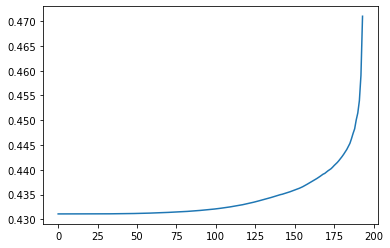

In [41]:
history["score"].plot();

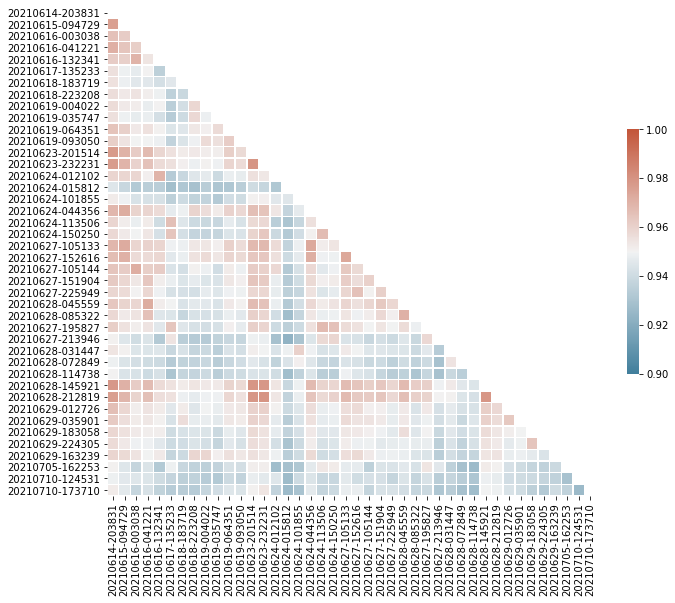

In [33]:
plot_heatmap(history.loc[idx, "models"])

In [34]:
# plt.scatter(oofs["dale_chall_readability_score"], oofs["target"])

In [35]:
# oofs["dale_chall_readability_score"].describe()